## _Topic Modeling based on Reviews_
***
<b>DESCRIPTION</b>

You are asked to analyze customer reviews from an e-commerce platform. More specifically, you will perform topic modeling to identify common themes in the reviews, apply POS tagging to extract grammatical information and utilize lemmatization to normalize the words for better
analysis.

<b>Problem Statement: </b>

A popular mobile phone brand, Lenovo has launched their budget smartphone in the Indian market. The client wants to understand the VOC (voice of the customer) on the product. This will be useful to not just evaluate the current product, but to also get some direction for developing the product pipeline. The client is particularly interested in the different aspects that customers care about. Product reviews by customers on a leading e-commerce site should provide a good view.

<b>Domain: Amazon reviews for a leading phone brand</b>

- Analysis to be done: POS tagging, topic modeling using LDA, and topic interpretation

<b> Content: </b>

- Dataset: ‘K8 Reviews v0.2.csv’

<b>Columns:</b>
- Sentiment: The sentiment against the review (4,5 star reviews are positive, 1,2 are negative)
- Reviews: The main text of the review

<b>Steps to perform:</b>

Discover the topics in the reviews and present it to business in a consumable format. Employ techniques in syntactic processing and topic modeling.
Perform specific cleanup, POS tagging, and restricting to relevant POS tags, then, perform topic modeling using LDA.

<b>Tasks: </b>
- Read the .csv file using Pandas. Take a look at the top few records.
- Normalize casings for the review text and extract the text into a list for easier manipulation.
- Tokenize the reviews using NLTKs word_tokenize function.
- Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.
- For the topic model, we should  want to include only nouns.
- Find out all the POS tags that correspond to nouns.
- Limit the data to only terms with these tags.
- Lemmatize.
- Different forms of the terms need to be treated as one.
- No need to provide POS tag to lemmatizer for now.
- Remove stopwords and punctuation (if there are any).
- Create a topic model using LDA on the cleaned up data with 12 topics.
- Print out the top terms for each topic.
- What is the coherence of the model with the c_v metric?
- Analyze the topics through the business lens.
- Determine which of the topics can be combined.
- Create topic model using LDA with what you think is the optimal number of topics
- What is the coherence of the model?
- Create a table with the topic name and the top 10 terms in each to present to the  business.



In [1]:
# write the list of necessary packages here:
!pip install pandas
!pip install nltk
!pip install spacy
!pip install scikit-learn
!pip install gensim
!pip install matplotlib
!pip install seaborn
!pip install tqdm
!pip install pyLDAvis

## _Import Libraries and Load the Data_

In [2]:
# import your packages here:
import numpy as np
import pandas as pd
import spacy
import string
from tqdm import tqdm
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#file and system operations
import os
import sys
#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#consistent sized plots
from pylab import rcParams
rcParams['figure.figsize']=12,5
rcParams['axes.labelsize']=12
rcParams['ytick.labelsize']=12
rcParams['xtick.labelsize']=12
#handle unwanted warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
#view all the columns
pd.options.display.max_columns = None
#basic text manipulation libraries
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### _Load the Reviews Data_

In [3]:
reviews = pd.read_csv('K8 Reviews v0.2.csv',delimiter=',')
reviews.head(3)

,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...


In [4]:
#check the number of reviews
len(reviews)

14675

In [5]:
#check the basic info
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14675 entries, 0 to 14674
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  14675 non-null  int64 
 1   review     14675 non-null  object
dtypes: int64(1), object(1)
memory usage: 229.4+ KB


- _There are no null values or missing values in the dataset_

In [6]:
#check the sentiment labels
reviews['sentiment'].value_counts()

,count
sentiment,
0,7712
1,6963


In [7]:
#sns.countplot(reviews['sentiment'])
#plt.title('Count of the review sentiments')
#plt.show()

- _The data seems to be fairly balanced. However, the objective of this project is to do topic modeling and not sentiment classification_

## _Text Preprocessing_
_Following steps will be performed_
- Tokenization - Split the text into sentences and sentences into words. Lowercase the words and remove any punctuation_
- All stopwords will be removed_
- Eliminate the tokens except nouns, noun phrases and verbs.
- Words are lemmatized - words in third person are changed to first person and words in future and past tense are changed to present tense_

In [8]:
nlp = spacy.load("en_core_web_sm")

# Define the preprocessing function
def preprocess_text(text):
    doc = nlp(text.lower())  # tokenization
    tokens = []

     # noun phrases
    for chunk in doc.noun_chunks:
        tokens.append(chunk.lemma_)

    # Nouns and verbs
    for token in doc:
      if token.is_stop == False and token.is_punct == False and token.is_alpha == True and (token.pos_ == "NOUN" or token.pos_ == "VERB"):
        tokens.append(token.lemma_)

    # Return the unique lemmatized tokens
    return list(dict.fromkeys(tokens))

In [9]:
# Apply preprocessing to review column
reviews['processed_review'] = reviews['review'].apply(preprocess_text)
print(reviews['processed_review'].head())

0                          [update, improvement, need]
1    [bad mobile, I, battery, hell, backup, only 6 ...
2    [I, my 10% cash, its already 15 january, cash,...
3                                                   []
4    [the bad phone, everthey, the last phone, the ...
Name: processed_review, dtype: object


In [10]:
reviews.iloc[0].T

,0
sentiment,1
review,Good but need updates and improvements
processed_review,"[update, improvement, need]"


In [11]:
reviews

,sentiment,review,processed_review
0,1,Good but need updates and improvements,"[update, improvement, need]"
1,0,"Worst mobile i have bought ever, Battery is dr...","[bad mobile, I, battery, hell, backup, only 6 ..."
2,1,when I will get my 10% cash back.... its alrea...,"[I, my 10% cash, its already 15 january, cash,..."
3,1,Good,[]
4,0,The worst phone everThey have changed the last...,"[the bad phone, everthey, the last phone, the ..."
...,...,...,...
14670,1,"I really like the phone, Everything is working...","[I, the phone, everything, fine whater, like, ..."
14671,1,The Lenovo K8 Note is awesome. It takes best p...,"[the lenovo k8 note, it, good picture, dual ca..."
14672,1,Awesome Gaget.. @ this price,"[awesome gaget, this price, gaget, price]"
14673,1,This phone is nice processing will be successf...,"[this phone, nice processing, successful but d..."


### Topic Modeling

Implement topic modeling using Latent Dirichlet Allocation (LDA) which is a topic modeling technique for uncovering the central topics and their distributions across a set of documents. Identify and list the top 5 topics found in the reviews along with their associated keywords.

In [12]:
# Create the dictionary and corpus for LDA
texts = reviews['processed_review'].tolist()

# Create a dictionary from the processed reviews
dictionary = corpora.Dictionary(texts)

# Create the document-term matrix (corpus)
corpus = [dictionary.doc2bow(text) for text in texts]

In [14]:
for nt in [2,3,5,7,10,12,15]:
  print(f"Number of topics: {nt}")
  lda_model = LdaModel(corpus, num_topics=nt, random_state=42, id2word=dictionary, passes=15)
  topics = lda_model.print_topics(num_words=5)
  for topic_num, topic in topics:
    print(f"Topic {topic_num}: {topic}")
  coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence_score = coherence_model.get_coherence()
  print(f"Coherence Score: {coherence_score}")
  print()
  print()

Number of topics: 3
Topic 0: 0.032*"phone" + 0.031*"product" + 0.026*"I" + 0.026*"it" + 0.014*"price"
Topic 1: 0.022*"phone" + 0.015*"I" + 0.013*"money" + 0.013*"mobile" + 0.012*"it"
Topic 2: 0.039*"battery" + 0.029*"camera" + 0.026*"phone" + 0.017*"it" + 0.016*"heating"
Coherence Score: 0.6816433852667698


Number of topics: 5
Topic 0: 0.033*"I" + 0.032*"it" + 0.026*"phone" + 0.013*"buy" + 0.013*"note"
Topic 1: 0.026*"money" + 0.021*"phone" + 0.012*"waste" + 0.011*"service" + 0.010*"value"
Topic 2: 0.040*"camera" + 0.024*"battery" + 0.019*"quality" + 0.018*"phone" + 0.016*"issue"
Topic 3: 0.050*"battery" + 0.029*"phone" + 0.029*"charge" + 0.022*"it" + 0.020*"problem"
Topic 4: 0.064*"product" + 0.053*"phone" + 0.042*"mobile" + 0.021*"price" + 0.020*"good phone"
Coherence Score: 0.6279988783077404


Number of topics: 7
Topic 0: 0.031*"it" + 0.031*"phone" + 0.024*"I" + 0.018*"camera" + 0.016*"feature"
Topic 1: 0.012*"support" + 0.012*"signal" + 0.009*"sim" + 0.008*"g" + 0.007*"network"
T

In [23]:
# Apply LDA with gensim
lda_model = LdaModel(corpus, num_topics=5, random_state=42, id2word=dictionary, passes=15)

# Print the topics and their top 5 words
topics = lda_model.print_topics(num_words=5)
for topic_num, topic in topics:
    print(f"Topic {topic_num}: {topic}")

Topic 0: 0.033*"I" + 0.032*"it" + 0.026*"phone" + 0.013*"buy" + 0.013*"note"
Topic 1: 0.026*"money" + 0.021*"phone" + 0.012*"waste" + 0.011*"service" + 0.010*"value"
Topic 2: 0.040*"camera" + 0.024*"battery" + 0.019*"quality" + 0.018*"phone" + 0.016*"issue"
Topic 3: 0.050*"battery" + 0.029*"phone" + 0.029*"charge" + 0.022*"it" + 0.020*"problem"
Topic 4: 0.064*"product" + 0.053*"phone" + 0.042*"mobile" + 0.021*"price" + 0.020*"good phone"


In [24]:
# Compute coherence score
coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.6279988783077404


In [25]:
# Visualize the topics
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


### Reporting

Summarizing the findings, including:
• How did you select the number of topics?
• Coherence score measures how semantically related the top words are in each topic.
Which coherence type did you employ (c v, u mass or uci)?
• The most common topics identified in the reviews.
• Print examples of reviews that belong to each topic.

How did you select the number of topics?

The selection of the optimal number of topics for LDA models can be based either on measures of topic quality (similarity or coherence) or on measures of goodness-of-fit and model complexity. models is determined by the numbers of topics in candidate models: K ∈ {Kmin,...,Kmax}. When choosing the number of topics, I first tried small values ​​like 3 and 5 and then looked at larger values ​​like 10 and 15. Here I tried to decide which would be better with the coherence score. A higher coherence score means more consistent results.
 https://www.jmlr.org/papers/volume25/23-0188/23-0188.pdf




 Coherence score measures how semantically related the top words are in each topic. Which coherence type did you employ (c v, u mass or uci)?

Coherence score is a measure of how semantically related the top words are in each topic. A higher coherence score indicates that the terms within a topic are more likely to be coherent (related). I prefered to use the c_v coherence type in my model.

There are different types.

c_v: This type is based on the pairwise similarity of the words in the topic and is considered one of the most reliable methods for assessing topic quality.

u_mass: Based on document co-occurrences of words and tends to give more information about word similarity.

u_ci: Combines pairwise word similarity with a sliding window model, typically used for more complex corpus structures.

I preper to use c_v coherence because it is based on how often words in a topic appear together in the corpus and their mutual information.

 https://groups.google.com/g/gensim/c/VJWdc-MdnrQ?pli=1

 https://www.baeldung.com/cs/topic-modeling-coherence-score


  The most common topics identified in the reviews.

  battery, phone, camera, I, charge

In [27]:
# Print examples of reviews that belong to each topic.
reviews['topic'] = [max(lda_model.get_document_topics(dictionary.doc2bow(text)), key=lambda x: x[1])[0] for text in reviews['processed_review']]

# Print examples of reviews that belong to each topic
num_examples = 5  # Number of reviews to print per topic
for topic_num in range(lda_model.num_topics):
    print(f"\n--- Topic {topic_num} ---")
    topic_reviews = reviews[reviews['topic'] == topic_num].head(num_examples)
    for idx, review in topic_reviews.iterrows():
        print(f"Review: {review['review']}")
        print("-" * 50)


--- Topic 0 ---
Review: when I will get my 10% cash back.... its already 15 January..
--------------------------------------------------
Review: Good
--------------------------------------------------
Review: Wrost
--------------------------------------------------
Review: headset is not available
--------------------------------------------------
Review: every time automatic on and off so kindly suggest me what i can do
--------------------------------------------------

--- Topic 1 ---
Review: Only I'm telling don't buyI'm totally disappointedPoor batteryPoor cameraWaste of money
--------------------------------------------------
Review: Not a good one. Dual SIM are not working. Poor customer service.
--------------------------------------------------
Review: Nice performance with 4gb RM and 64gb inbuilt memory
--------------------------------------------------
Review: Value for money
--------------------------------------------------
Review: India ka werorst mobile . Battery fully 

### Visualization

Plot word clouds for each topic displaying associated keywords

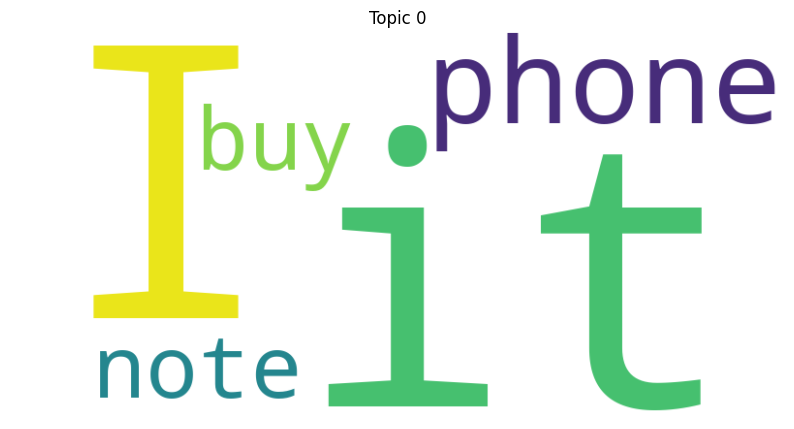

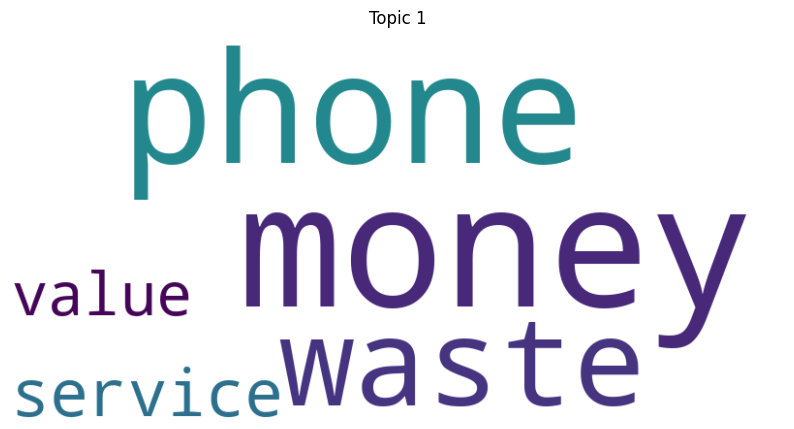

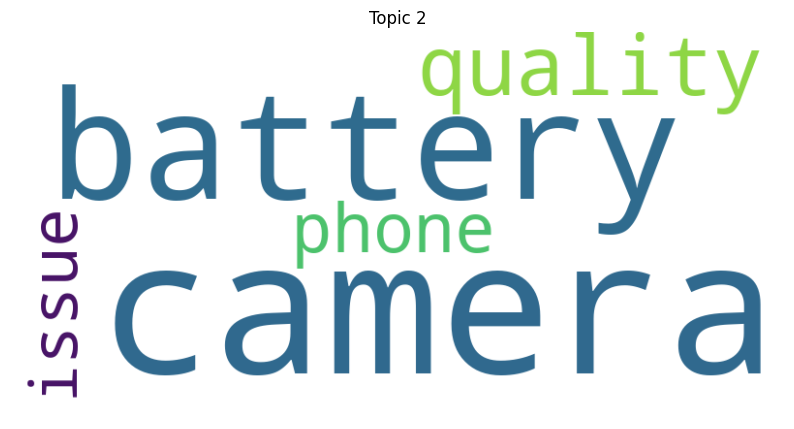

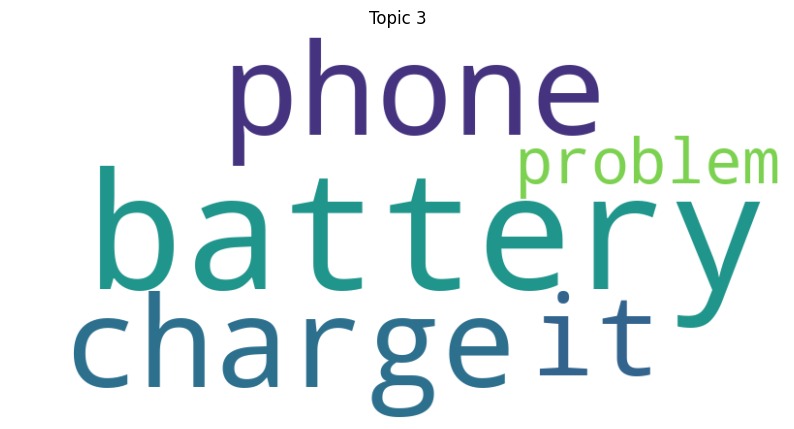

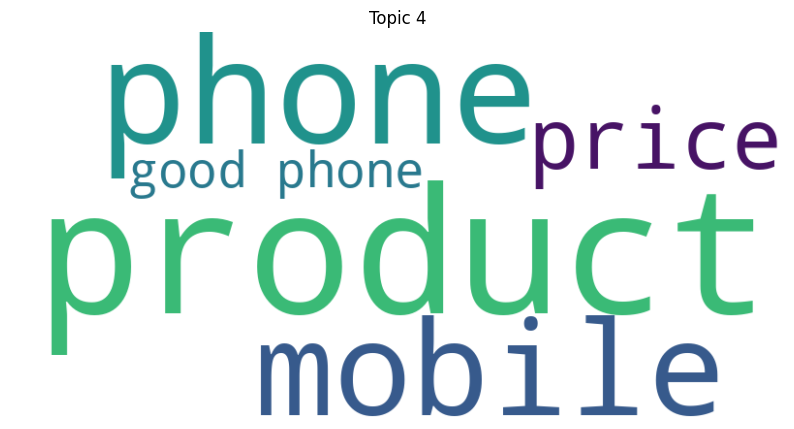

In [26]:
# Number of topics (adjust this as needed)
num_topics = lda_model.num_topics

# Create word clouds for each topic
for topic_num in range(num_topics):
    # Get the top 5 words for the topic
    topic_words = lda_model.show_topic(topic_num, topn=5)

    # Create a dictionary of words and their probabilities
    word_freq = {word: prob for word, prob in topic_words}

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_num}")
    plt.show()